In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

Срок выполнения задания: 17 марта 17:00.


### Задание
Вам предстоит разработать дизайн эксперимента по тестированию монетизационных продуктов.
В конечном счёте, в монтизационных продуктах нас всегда интересует увеличение выручки, 
но к сожалению не всегда мы можем зафиксировать изменение именно этой метрики.

#### Кейс
Вы аналитик в продуктовой дискавери команде.
На текущий момент приближается начало нового квартала и вам необходимо спланировать
эксперименты в нём.

У вас есть два продукта:
- один базовый продукт, который предоставляет минимальный набор услуг на вашем ресурсе;
- один продвинутый продукт, который предоставляет расширенный набор услуг.

На текущий момент на квартал у вашей команды есть для проверки две гипотезы:
- Дополнительное информирование об эффективности услуг будет стимулировать их покупку;
- Повышение цены базового продукта должно стимулировать покупку продвинутого продукта


#### Для планирования эксперимента изучите данные и метрики (2 балла):

- Загрузите файл и изучите данные;
- Подумайте над тем, какие метрики можно выделить на основе этих данных: выручка, пользователи, транзакции, средний чек и т.д.
- Постройте графики плотности распределения для этих метрик и сделайте выводы о характере распределений: тип, наличие выбросов, насколько сильный разброс;
- Изучите основные статистики этих метрик: среднее, стандартное отклонение;
- Изучите то, насколько эти статистики подвержены сезональности.


#### Формализуйте гипотезы (4 балла):

- Опишите метрики и статистики, изменение которых вы ожидаете;
- Предположите какое относительное изменение этих статистик в процентах вы ожидаете.

#### Предскажите минимально детектируемый эффект для своих метрик и спланируйте эксперименты внутри квартала (4 балла):

- Принимая в расчёт максимально возможные размеры групп и ограничения по длительности в квартал рассмотрите разные планы проведения тестов и предскажите их чувствительность;
- Определите наиболее оптимальный план экспериментов. Обоснуйте, почему вы его считаете оптимальным.


#### * Оптимизация плана (2 балла):
Предложите варианты ускорения экспериментов — всегда могут образоваться ситуации, когда ваши гипотезы не подтвердились и они требуют изменения или уточнения и необходимости повторных тестов. Цели достигать всегда хорошо в рамках отведённого на них срока. Какие параметры экспериментов вы поменяете? К каким последствиям могут привести такие изменения?

#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

product - тип продукта

amount - сумма покупок

transactions - количество транзакций


In [413]:
df = pd.read_csv('user_transactions.csv')
df['event_date']=df.event_date.apply(date_converter)

**1.2**

In [414]:
df.head()

,event_date,user_id,product,amount,transactions
0,2020-09-29,40746820883461494,basic,95.0,1
1,2020-09-29,41102328408008828,advanced,279.0,1
2,2020-09-29,63464894315144075,basic,64.0,1
3,2020-09-29,111526991873455341,basic,399.0,1
4,2020-09-29,169522572963414231,basic,199.0,1


По первой гипотезе **Дополнительное информирование об эффективности услуг будет стимулировать их покупку**  
Можно следить за средним числом транзакций на человека, если наша гипотеза верна мы должны зафикисировать увеличение кол-ва транзакций

In [415]:
df[df.event_date <= '2020-10-29'].groupby('user_id')[['transactions']].sum().sort_values('transactions').mean()

transactions    2.709829
dtype: float64

In [416]:
t1 = df.groupby('user_id')[['transactions']].sum().sort_values('transactions')

In [417]:
t1.mean(), t1.std()

(transactions    3.696954
 dtype: float64,
 transactions    16.522523
 dtype: float64)

In [418]:
t1

,transactions
user_id,
1809139296429,1
5344331396494370992,1
5344326684694287712,1
5344194258139191888,1
5344111954550540771,1
...,...
3966550629130324075,1660
6742339174893016914,1842
4687659281811086218,1919


(array([264020.,  72267.,  31774.,  18017.,  11342.,   7972.,   5717.,
          4375.,   3450.,   2894.,   2339.,   1981.,   1731.,   1466.,
          1366.,   1145.,    996.,    903.,    822.,    731.,    638.,
           618.,    579.,    545.,    414.,    467.,    387.,    368.,
           674.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30.]),
 <BarContainer object of 29 artists>)

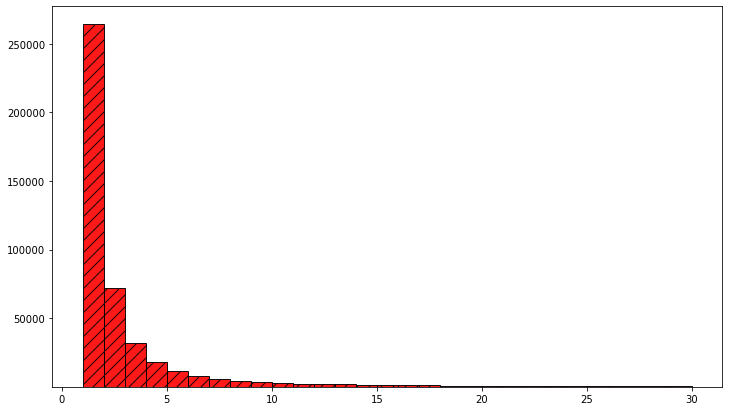

In [419]:
fig, ax = plt.subplots(figsize = (12, 7))
ax.hist(t1, bins = 29, # bins - целое число, оно определяет количество интервалов одинаковой ширины в диапазоне
        zorder = 3, range = (1, 30), # Нижние и верхние выбросы игнорируются? если не указан, диапазон равен (x.min (), x.max ())
        density = False,  # density = True - нормировка по оси y прощади на 1
        alpha = 0.9,
        bottom = 0.2, # смещение на 0.2 вверх
        rwidth = 1, # толщина столбца rwidth
        color = 'red', # цвет столбца
        edgecolor = 'black', # цвет края
        hatch = '//') # hatch - штриховка

Для второй гипотезы **Повышение цены базового продукта должно стимулировать покупку продвинутого продукта**  
Будем следить за средним числом транзакций типа **advanced** на человека 

In [420]:
df_adv = df[df['product'] == 'advanced']

In [421]:
k = df[df['product'] == 'basic']

In [422]:
k['transactions'] = 0

C:\Users\rimbb\AppData\Local\Temp/ipykernel_6896/2561725182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k['transactions'] = 0


In [423]:
k.head(3)

,event_date,user_id,product,amount,transactions
0,2020-09-29,40746820883461494,basic,95.0,0
2,2020-09-29,63464894315144075,basic,64.0,0
3,2020-09-29,111526991873455341,basic,399.0,0


In [424]:
df_adv = pd.concat([df_adv, k])

In [425]:
t2 = df_adv.groupby('user_id')[['transactions']].sum()

In [426]:
t2.sort_values('transactions')

,transactions
user_id,
3568088068926032400,0
4694856454543314309,0
7860694008857519131,0
7860702471578515343,0
4694811811441249291,0
...,...
5514140398139570480,942
1103911032967574635,1011
5775752295582531623,1050


In [427]:
t2.mean()

transactions    0.823084
dtype: float64

(array([3.28029e+05, 8.32720e+04, 1.64830e+04, 6.09000e+03, 3.03100e+03,
        1.83900e+03, 1.23400e+03, 8.37000e+02, 6.31000e+02, 4.97000e+02,
        4.17000e+02, 3.45000e+02, 2.94000e+02, 2.71000e+02, 2.36000e+02,
        1.90000e+02, 1.63000e+02, 1.69000e+02, 1.41000e+02, 1.29000e+02,
        1.25000e+02, 1.04000e+02, 1.01000e+02, 9.10000e+01, 7.90000e+01,
        7.70000e+01, 7.70000e+01, 9.10000e+01, 5.80000e+01, 1.33000e+02]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30.]),
 <BarContainer object of 30 artists>)

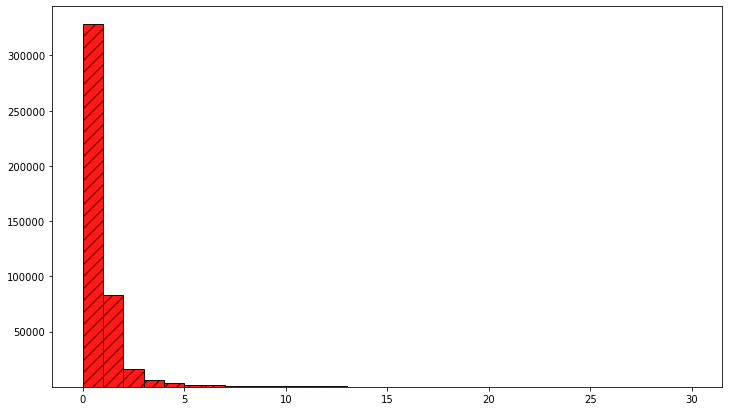

In [428]:
fig, ax = plt.subplots(figsize = (12, 7))
ax.hist(t2, bins = 30, # bins - целое число, оно определяет количество интервалов одинаковой ширины в диапазоне
        zorder = 3, range = (0, 30), # Нижние и верхние выбросы игнорируются? если не указан, диапазон равен (x.min (), x.max ())
        density = False,  # density = True - нормировка по оси y прощади на 1
        alpha = 0.9,
        bottom = 0.2, # смещение на 0.2 вверх
        rwidth = 1, # толщина столбца rwidth
        color = 'red', # цвет столбца
        edgecolor = 'black', # цвет края
        hatch = '//') # hatch - штриховка

**1.3**

Для первой гипотезы ожидается увеличение среднего числа транзакций на человека, размер эффекта будет зависеть от того насколько хорошо будет сделано информирование
Ожидаемое изменение: если в течении месяца каждый 10 человек сделает на 1 транзакцию больше, то относительный эфaект будет 4%

Для второй гипотезы ожидается увеличение среднего числа транзакций типа advanced на человека, размер эффекта опять же зависит от механики эксперимента, т.е от того насколько сильно будет повышена базовая цена и соотношения полезности базового и продвинутого продуктов
Ожидаемое изменение: Если каждый 20 потребительй только базового продукта совершит хотябы одну транзакцию, то эффект составит 5%

**1.4**

mde гипотеза 1

In [430]:
def choose_date(data, start_date, delta, share): 
    tmp = data[(data.event_date>=start_date)&(data.event_date<=start_date+datetime.timedelta(days=delta))]
 #   tmp=tmp.groupby(['user_id']).sum().reset_index()
    tmp = tmp.groupby('user_id').sum().reset_index()
    x = tmp[(tmp.user_id)%int(1/share)==0].reset_index()
    return x

In [431]:
x1 =choose_date(df, datetime.datetime(2020, 9, 29, 0, 0),82,0.5) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.transactions.mean()
std = x1.transactions.std()
 
alpha = 0.02
power = 0.8
result_effect = 0.045 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

1.024826832751077


mde гипотеза 2

In [432]:
def choose_date2(data, start_date, delta, share): 
    tmp = data[(data.event_date>=start_date)&(data.event_date<=start_date+datetime.timedelta(days=delta))]
    
 #   tmp=tmp.groupby(['user_id']).sum().reset_index()
    df_adv = tmp[tmp['product'] == 'advanced']
    k = tmp[tmp['product'] == 'basic']
    k['transactions'] = 0
    tmp = pd.concat([df_adv, k])
    
    tmp = tmp.groupby('user_id').sum().reset_index()
    x = tmp[(tmp.user_id)%int(1/share)==0].reset_index()
    return x

In [436]:
x2 =choose_date2(df, datetime.datetime(2020, 9, 29, 0, 0),9,0.1) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x2.transactions.mean()
std = x2.transactions.std()
 
alpha = 0.02
power = 0.8
result_effect = 0.05 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
     
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

0.8505006433523702


C:\Users\rimbb\AppData\Local\Temp/ipykernel_6896/306584304.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k['transactions'] = 0
